In [1]:
import matplotlib.pyplot as plt
import numpy as np

<!-- ![alt text](SumBlock.png "Title") -->
# Negative feedback control example

<div> <img src="feedback_system.png" alt="Drawing" style="width: 700px;"/> </div>

In this notebook, you will find code, with detailed explanations, for a system like the negative feedback control example from Lecture 3.2.

The system is programmed using classes. I always prefer the object-oriented approach to coding, and define every kind of system as a class, as you will see when I share more examples with you later in the module.

In Lecture 1, I mentioned that one of the advantages of simulating systems is that you have access to all of the systems' variables. In the code here, as usual in my code, I keep records of all of the systems' variables for later plotting and analysis of results.

One other feature that you will notice that all of my system classes have in common is a ``step`` method. The simulation in this notebook runs in discrete time, and moves forwards in time in steps. In every simulation step, all system objects are stepped forwards, and their outputs are updated, in their ``step`` methods.

## Proportional controller
<!-- ![alt text](ProportionalController.png "Title") -->
<div> <img src="ProportionalController.png" alt="Drawing" style="width: 400px;"/> </div>

The first element of the negative feedback controlled system which we will look at is the controller, defined in the ProportionalController class. As I mention in the lecture, this particular controller, which is very simple, is referred to as a proportional controller bacause its output, *c* is proportional to its input (which is the *error*, *e*, in our negative feedback loop). It has a single parameter which can be adjusted, which is the *controller gain*, *k*. If the gain is *> 1*, then the controller amplifies the error. If the gain is *1* then the controller has no effect. If the gain is less than one, then the controller attenuates the error. If the gain is *0*, then the controller breaks the feedback loop, as it will output *0* all the time, regardless of the magnitude of the error.

In [2]:
class ProportionalController:

    def __init__(self, k):
        # controller gain
        self.k = k
        # we will keep a record of the outputs from the controller for plotting later
        self.outputs = [0]

    def step(self, e):
        # compute the controller output
        c = self.k * e
        # keep a record of the output
        self.outputs.append(c)
        # return the output
        return c

## Summing block
<!-- ![alt text](SumBlock.png "Title") -->
<div> <img src="SumBlock.png" alt="Drawing" style="width: 400px;"/> </div>

The next element that we will consider is the summing element. In the negative feedback system, this element adds the reference signal, *r*, to the *negative* of the error. 

Although we have not yet reached the positive feedback lecture, I have made it possible to switch the feedback from negative to positive in this code, in case you want a preview of what difference a simple change of feedback sign makes to how the system behaves.

In [3]:
class SumBlock:

    def __init__(self, sign="negative"):
        # if incorrect strings are passed in, then the code will not run 
        assert sign == "negative" or sign == "positive", "Sign must be either 'negative' or 'positive'"
        # set the feedback sign to negative by default
        self.feedback_sign = -1
        # if "positive" is specified, then set the feedback sign to positive
        if sign == "positive":
            self.feedback_sign = 1
        # keep a record of the block's outputs for plotting later
        self.outputs = [0]

    def step(self, o, r):
        # compute the error
        e = r + (self.feedback_sign * o)
        # keep a record of the error for later
        self.outputs.append(e)
        # return the error
        return e

## Integrator (the controlled system)
<!-- ![alt text](IntegratingSystem.png "Title") -->
<div> <img src="IntegratingSystem.png" alt="Drawing" style="width: 400px;"/> </div>

The next element that we consider is the system which is being controlled. As in the lecture, this system is a simple integrator, but I have made one change, for a reason which I will explain later in this notebook. In the example from the lecture, I allowed the integrator to immediately integrate its inputs. In the real world, systems' variables tend to be resistant to change - to varying extents, they "push back" when "pushed" by their inputs. In the code here, the amount to which the integrator pushes back is determined by the parameter *tau*. If *tau* is very large, then the system will respond slowly to its inputs. If *tau* is equal to *1*, then the system responds exactly as in the lecture example. If *tau* is less than *1*, then the system will respond very quickly, and will effectively amplify its inputs.  

In [4]:
class IntegratingSystem:

    def __init__(self, initial_o, tau=1):
        # set initial state (output) of system
        self.o = initial_o
        # keep a record of the system's outputs for later
        self.os = [initial_o]
        # set the system's parameter, which determines how quickly it integrates its inputs 
        self.tau = tau

    def step(self, c):
        # integrate the system's input, at the rate set by tau
        self.o += c / self.tau
        # keep a record of the system's output
        self.os.append(self.o)
        # return the system's output
        return self.o

## The complete system

Each of the elements which we have considered so far has one or more inputs, and a single output. On their own, none of the elements do anything particularly interesting, or complex. However, as we saw in the lecture, when we connect these elements into a single system, with the correct organisation (a closed loop) then the result is an interesting and powerful system. Every time the simulation moves forwards in time by one step, we go round the loop once. We begin by calculating the present error value, *e*, which is fed into the controller, which then produces the control output which is fed into the integrator. Finally the integrator output is computed.

In [5]:
class FeedbackControlledSystem:

    def __init__(self, controller, summer, controlled_system):
        # set the elements of the system
        self.controller = controller
        self.summer = summer
        self.controlled_system = controlled_system

    def step(self, r):
        # go round the closed loop one element at a time 
        # - for each element, run its step method to update its output, and then pass that output into the next element
        # - note that to close the loop, we have to begin by accessing the previous value of the integrator output,
        #   using self.controlled_system.o
        
        # get the summer block to compute the error, e
        e = self.summer.step(self.controlled_system.o, r)
        # get the controller to compute its output, c
        c = self.controller.step(e)
        # get the integrator to update its output, or state
        o = self.controlled_system.step(c)
        return o

## Preparing the system

Preparing the system is quite straightforward. We set up the elements of the system, by creating instances (i.e.) objects of their respective classes which are defined above. In the case of the controller, we need to specify the gain parameter, *k*. In the case of the sum block, we don't need to specify the parameter unless we want to - if we don't specify the sign parameter, then it will default to ``negative``, but we can also specify ``"positive"`` or ``"negative"`` for this parameter if we want to. In the case of the integrator, we have to specify the initial state, or output, but specifying the ``tau`` parameter is optional. If we don't specify the value for this parameter, then it will default to *1*.

In [6]:
# set up the system's elements
controller = ProportionalController(k = 0.1)
summer = SumBlock()
controlled_system = IntegratingSystem(initial_o = 0)
# connect the elements to make the larger system
fc_system = FeedbackControlledSystem(controller, summer, controlled_system)

## The simulation loop

To run the simulation, we use a ``for`` loop (we won't always do this - sometimes a ``while`` loop is more convenient, as I will show you later in the module). For a predetermined number of simulation steps, we update the system one step at a time, in just the same way as in the lecture. 

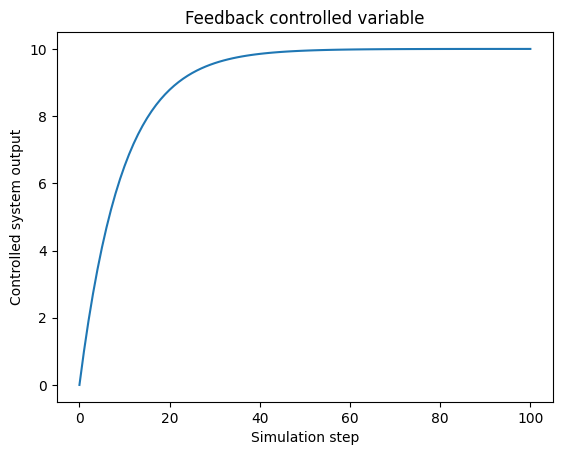

In [7]:
# we will simulate for a set number of steps
steps = 100
# in this example, we will have a constant-valued reference signal, as in the lecture
r = 10
# run the simulation for the specified number of steps
for _ in range(steps):
    # step the system forwards in time
    fc_system.step(r)

plt.xlabel("Simulation step")
plt.ylabel("Controlled system output")
plt.title("Feedback controlled variable")
    
# plot the output of the integrator
plt.plot(controlled_system.os)



## The problem with gain

In the lecture example, the system will always behave in the same way, for valid values of *k*. However, that is only the case because the controlled system (the integrator) is so well behaved. In the example below, I have made the integrator's ``tau`` parameter small, so that it amplifies its input. In this case, a controller gain, *k*, of greater than *1* will lead to instability in the system, effectively turning a negative feedback loop into a positive one.

In other words, *k* should be in the interval *(0, 1]* for this system, and the system will not behave correctly for other values of *k*. Look at what happens below when I run the system with *k = 1* and then *k = 1.1*.

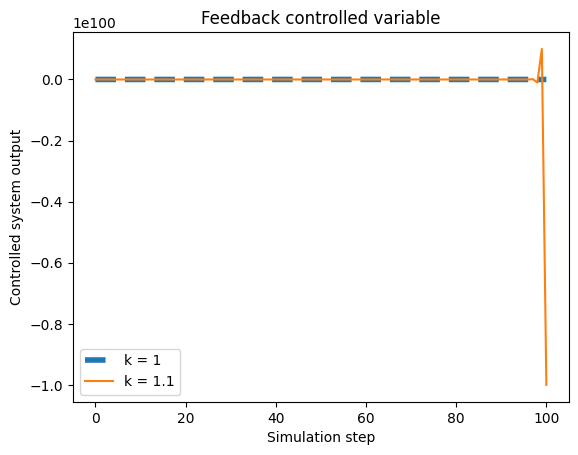

In [8]:
'''
First we will run the system with k = 1
'''

# set up the system
controller = ProportionalController(k = 1)
summer = SumBlock()
controlled_system = IntegratingSystem(initial_o = 9, tau=0.1)
fc_system = FeedbackControlledSystem(controller, summer, controlled_system)

# we will simulate for a set number of steps
steps = 100
# in this example, we will have a constant-valued reference signal, as in the lecture
r = 10
# run the simulation for the specified number of steps
for _ in range(steps):
    # step the system forwards in time
    fc_system.step(r)

# plot the output of the integrator
plt.plot(controlled_system.os, '--', label="k = 1", linewidth=4)

'''
Now we run the system again with no changes except for k = 1.1
'''

# set up the system
controller = ProportionalController(k = 1.1)
summer = SumBlock()
controlled_system = IntegratingSystem(initial_o = 9, tau=0.1)
fc_system = FeedbackControlledSystem(controller, summer, controlled_system)

# we will simulate for a set number of steps
steps = 100
# in this example, we will have a constant-valued reference signal, as in the lecture
r = 10
# run the simulation for the specified number of steps
for _ in range(steps):
    # step the system forwards in time
    fc_system.step(r)

# plot the output of the integrator
plt.plot(controlled_system.os, label = "k = 1.1")

plt.xlabel("Simulation step")
plt.ylabel("Controlled system output")
plt.title("Feedback controlled variable")


plt.legend()

What we see in the plot for *k = 1.1* is an example of overshoot. In the first step of the simulation, the error is 10, but the controller output is 11. This makes the integrator move too far - it goes past the reference point, unlike the case where *k = 1*, which corrects the error immediately. 

For a proportional controller, the correct interval for the value of *k* will depend on how quickly the controlled variable(s) change, and this is why I added the *tau* parameter to my integrator. See what happens below when I change the tau parameter of the integrator. 

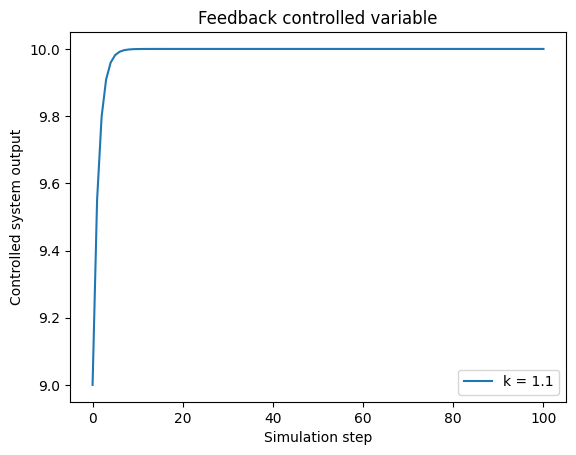

In [9]:
# set up the system
controller = ProportionalController(k = 1.1)
summer = SumBlock()
controlled_system = IntegratingSystem(initial_o = 9, tau = 2)
fc_system = FeedbackControlledSystem(controller, summer, controlled_system)

# we will simulate for a set number of steps
steps = 100
# in this example, we will have a constant-valued reference signal, as in the lecture
r = 10
# run the simulation for the specified number of steps
for _ in range(steps):
    # step the system forwards in time
    fc_system.step(r)

# plot the output of the integrator
plt.plot(controlled_system.os, label = "k = 1.1")

plt.xlabel("Simulation step")
plt.ylabel("Controlled system output")
plt.title("Feedback controlled variable")


plt.legend()

Now we see that *k = 1.1* is not a problem, but there will be some value of *k* for this system which is too large - we just haven't identified it yet.

To summarise, the more slowly the controlled variable changes, the larger *tau* will be, and the larger *k* can be without causing any problems. Actually, for the relatively simple system modelled in this notebook, if we want our controller to change the controlled variable as quckly as possible, we want *k* to be large, but not too large, so it is a good idea for us to find the largest value of *k* which will work. It is not especially difficult to do this mathematically, for the simple system in this example, but we can also find or *approximate* it through experiment. For example, we can start with a low value of *k* and keep increasing it until we see the system begin to behave incorrectly, and then go back to the last value of *k* which was good.

# Time-varying reference signals

As I mention in the lecture, the reference signal that we pass into a feedback controlled system may be constant, or it may vary over time. For example, if you want to control the temperature of a room, you set your thermostat to a constant value, but if you want to control the *movement* of a robot or animal joint, then *r* must also "move" over time. In the example below, I make the reference signal sinusoidal, so that you can see that a negative feedback controlled system can track time-varying reference signals as well as constant ones - to a negative feedback controller, an error is an error - whenever an error appears, and for whatever reason it appears, the system will act in such a way as to reduce (or eliminate, if possible) the error.  

You will notice that the system output tracks the input very well, except for a small delay. In any system with feedback, there will always be some delay in the feedback path. In this example, the delay comes from the simulation itself - it takes a single simulation step for the feedback to reach the controller - I have not explicitly modelled any delay. A better simulation would include that delay, as well as an explicit time variable rather than just discrete steps.

A better controller, such as a proportional-integral (PI) or proportional-integral-derivative (PID) controller would have the potential to reduce the effect of the delay.

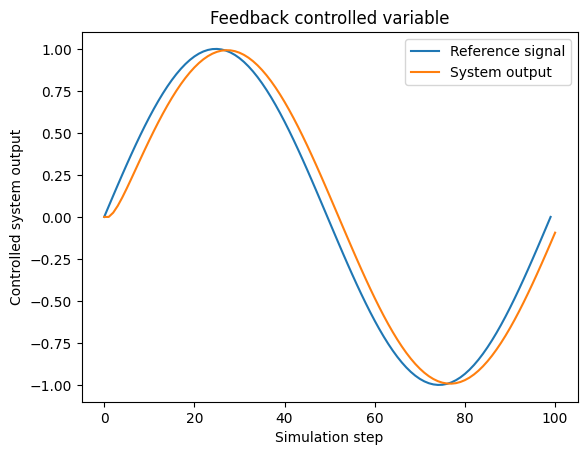

In [10]:
controller = ProportionalController(k = 0.4)
summer = SumBlock()
controlled_system = IntegratingSystem(initial_o = 0)
fc_system = FeedbackControlledSystem(controller, summer, controlled_system)

steps = 100
xs = np.linspace(0, 2*np.pi, num=steps)
rs = np.sin(xs)
for r in rs:
    fc_system.step(r)

plt.plot(rs, label='Reference signal')
plt.plot(controlled_system.os, label='System output')

plt.xlabel("Simulation step")
plt.ylabel("Controlled system output")
plt.title("Feedback controlled variable")

plt.legend()


There is more that I could show you in this notebook, but I'm not going to do all of the work for you. To gain a more full understanding of this system, you should experiment with its parameters. 

For example, you might investigate what happens if *k* is extremely large. What will happen to the system's output then?

You might also want to plot the outputs of the summing block and the controller, to see how they correspond to the output of the system.

## Please ask questions!

I would like you to experiment with this system, and see what happens when you run the simulation with different parameters for the elements in the system. I don't expect you to immediately understand the results you get from doing this - if you see some results which you don't understand, then please ask me to explain, on the padlet for Lecture 3. Remember that your questions will be anonymous on the padlet, so no-one will know who asked the question but everyone will be able to read it, and see my answers. 

Please also ask questions on the padlet (or by email, or in class) if you have any problems with running the code, and I can also help with that.